<a href="https://colab.research.google.com/github/orattanathon/RL/blob/main/4_2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    


In [3]:
env = gym.make('Blackjack-v0')

In [4]:
def gen_random_policy(nA):
  # obtains the action probabilities
  A = np.ones(nA, dtype=float)/ nA
  def policy_s(observation):
    return A
  return policy_s

In [5]:
def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    episode = []
    done = False
    while not done:
        probs = behavior_policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        actions.append(action)
        states.append(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return states, actions, rewards, episode

In [6]:
def create_greedy_policy(Q):
  def policy_s(state):
    A = np.zeros_like(Q[state], dtype=float)
    best_a = np.argmax(Q[state])
    A[best_a] = 1.0
    return A
  return policy_s

In [14]:
def mc_control_off_policy_weightedSampling(env, num_episodes, behavior_policy, gamma=1.0):

  C = defaultdict(lambda: np.zeros(env.action_space.n))

  Q = defaultdict(lambda: np.zeros(env.action_space.n))
 
  target_policy = {}

  for i_episode in range(1,num_episodes+1):

      if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
      states_t, actions_t, rewards_t, episode_t = run_episode(env, behavior_policy)
      G = 0.0 #return
      W = 1.0
      for i in range(len(episode_t))[::-1]:
         state, action, reward = episode_t[i]
         G = gamma* G + reward
         C[state][action] += W
         Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
         if action !=  np.argmax(Q[state]).item():
            break
         W = W * 1./behavior_policy(state)[action]
  for state, actions in Q.items():
        target_policy[state] = np.argmax(actions).item()

  return Q, target_policy


In [15]:
Q, target_policy = mc_control_off_policy_weightedSampling(env, num_episodes=500000, behavior_policy=gen_random_policy(env.action_space.n))

Episode 500000/500000.

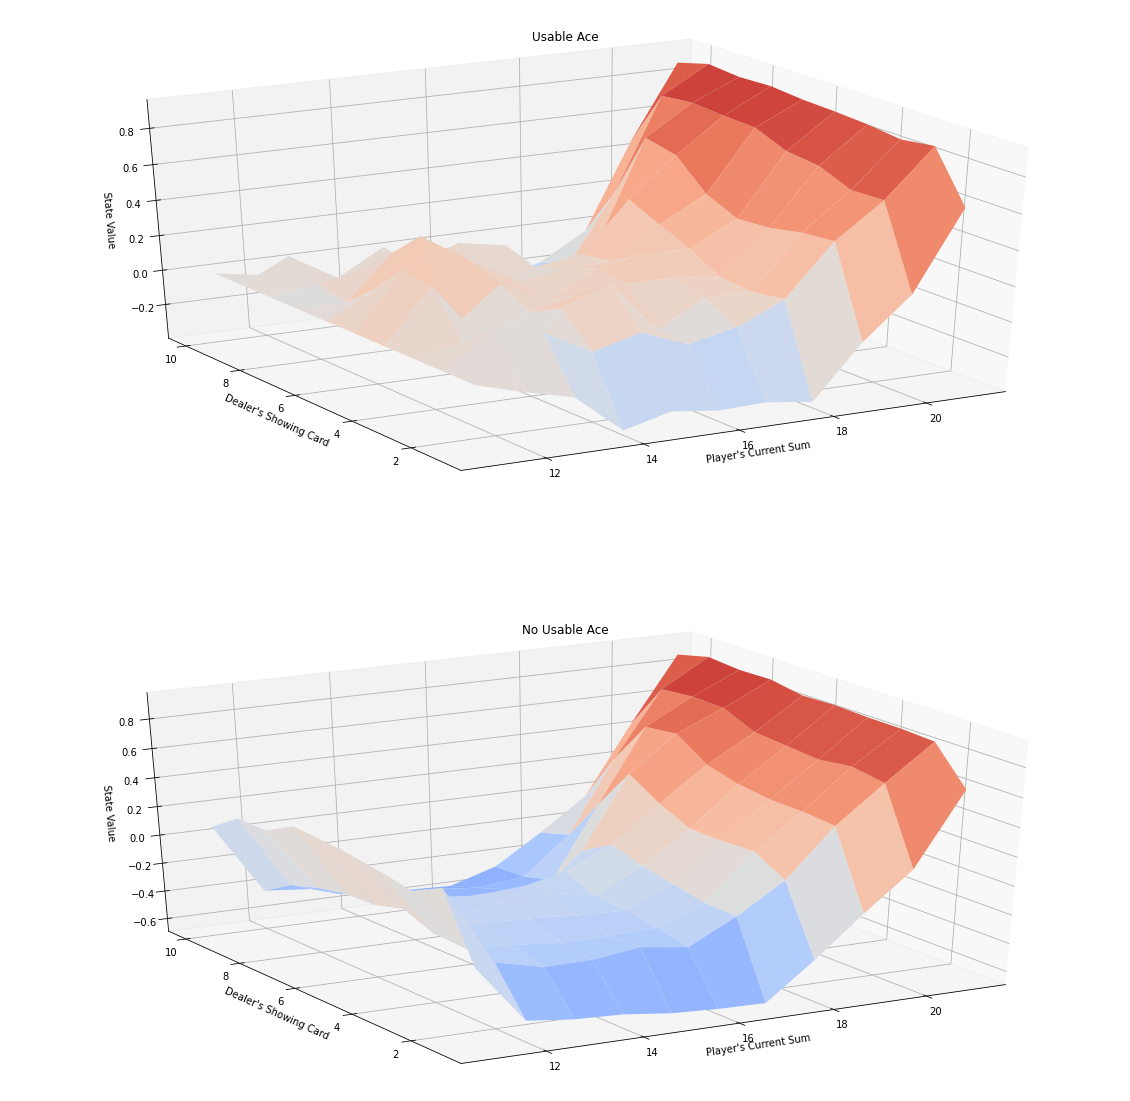

In [9]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
#obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

#plot the state-value function
plot_blackjack_values(V)    

In [10]:
def simulation(env, policy):
    state = env.reset()
    done = False
    while not done:
        action = policy[state]
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            return reward

win rate 0.42915 loss rate 0.47869 draw rate 0.09216 Average return -0.04954


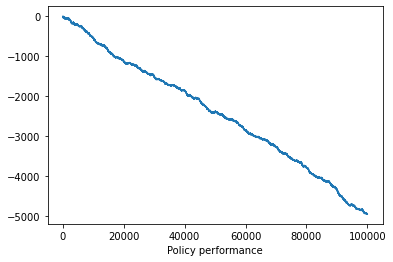

In [16]:
n_episode = 100000
n_lose = 0
n_draw = 0
n_win = 0
rewards = np.zeros(n_episode)
totalReward = 0

for i in range(n_episode):
    reward = simulation(env, target_policy)
    totalReward += reward
    rewards[i] = totalReward

    if reward == 1:
        n_win += 1
    if reward == 0:
        n_draw += 1
    elif reward == -1:
        n_lose += 1

n_win /= n_episode
n_lose /= n_episode
n_draw /= n_episode
totalReward /= n_episode
print('win rate', n_win, 'loss rate', n_lose, 'draw rate', n_draw, 'Average return', totalReward)
plt.plot(rewards)
plt.xlabel("Policy performance")
plt.show()